
# 1) Intro — Multi-Agent Nutritionist (Two Models)

This workshop uses **two cooperating agents**:

- **Consultant (Medical Expert) — `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`**  
  Acts as the *brain* for our medical expert agent. It has access to a **local OpenNutrition DB** (ingredient/nutrition data + potential health warnings).  
  It **assesses the ingredients** of a provided food item and returns an expert analysis plus **healthier alternatives**.

- **Orchestrator (Vision + Retrieval) — `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`**  
  Accepts **images (labels/barcodes)** or **text**. Uses **OpenFoodFacts (OFF) API** tools to gather ingredients.  
  If OFF fails, it uses **EXA via MCP** as a fallback web search.  
  Finally, it **consults the expert agent** and produces a full analysis and suggested **healthier alternatives**.
  

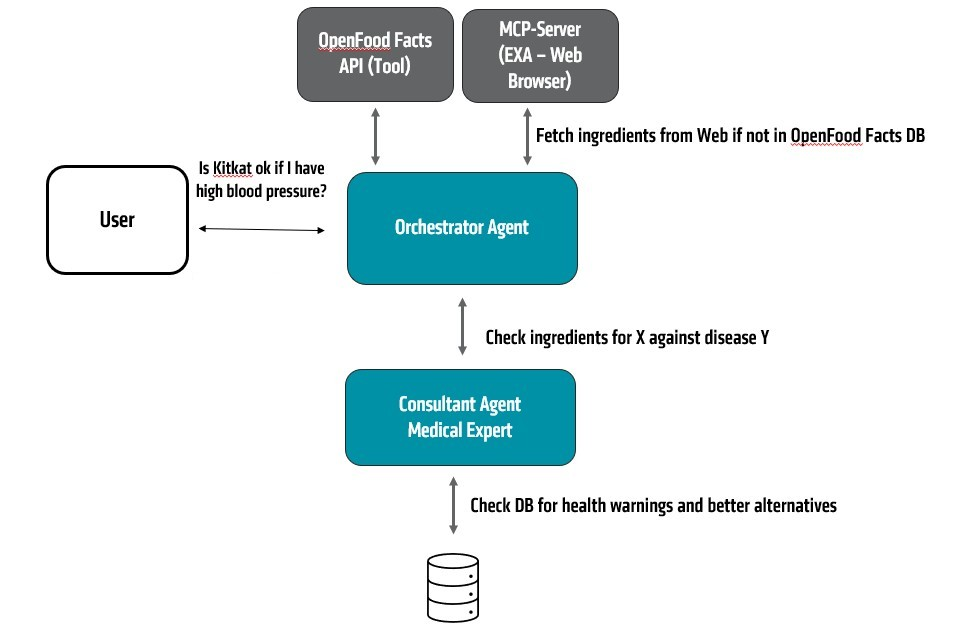


# 2) Flow, Goals, and Agenda

## Flow (High Level)
1. Orchestrator receives input (image/barcode/text) for a snack/food.
2. Orchestrator looks up **ingredients** using **OFF API**; if not found, uses **EXA (MCP)**.
3. Orchestrator passes clean ingredients (or product name) to **Consultant**.
4. Consultant evaluates risks, flags concerns, and proposes **healthier alternatives**.
5. Orchestrator returns a concise, user-friendly **verdict + reasons + alternatives**.

## What You Will Build
- A **Vision-capable Orchestrator agent** (Qwen VL) with tools for **OFF** and **EXA (MCP)**.
- A **Consultant agent** (Qwen 30B text) backed by a **local OpenNutrition DB** toolset.
- The **glue** that lets the Orchestrator consult the Consultant automatically.

## What You Will Learn
- Running **open-weights** models with **vLLM** and **tool calling**.
- Turning LLMs into **agents** using **Pydantic AI**.
- Turning a **local DB** into a **callable tool** for an AI agent.
- Turning an **external API** (OpenFoodFacts) into a **callable tool**.
- Connecting a **web browser** using **MCP** with **EXA**.
- Wiring up **two agents to collaborate** on one task.

## Agenda (You’ll fill in the code cells)
1. Pre-reqs
2. Install dependencies & imports
3. Verify model endpoints
4. Smoke test the **Consultant** model
5. Build **Consultant** agent + tools (local DB)
6. Build **Orchestrator** agent + tools (OFF + EXA fallback)
7. Glue: Orchestrator calls Consultant
8. E2E examples



# 3) Pre-reqs — Running Two Models with vLLM

Briefly describe your environment and GPU (e.g., AMD ROCm + MI300X).  
You will launch **two** model servers in separate terminals:

- **Consultant**: `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on **:9000**  
- **Orchestrator**: `Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on **:9001**

> Tip: Start them **sequentially** to avoid OOM.

Start both model endpoints in **separate terminals** so the Orchestrator and Consultant are available.

### Consultant (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) on port **9000**




```bash
VLLM_ATTENTION_BACKEND=TORCH_SDPA \
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-30B-A3B-Instruct-2507-FP8 \
  --port 9000 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



### Orchestrator (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8`) on port **9001**
```bash
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-VL-30B-A3B-Instruct-FP8 \
  --port 9001 \
  --enable-auto-tool-choice \
  --tool-call-parser hermes \
  --trust-remote-code \
  --gpu-memory_utilization 0.45
```



# 4) Install Pre-reqs and Imports

Let's installs all the libraries, then import what you need.  

In [1]:
# #Added requirements
# !pip install httpx
# !pip install google-adk[extensions]==1.25.0
# !pip install openfoodfacts==3.4.3
# !pip install weave==0.52.26

In [2]:
## !pip -q install pydantic_ai openai httpx

# UNCOMMENT BELOW IF YOU HAVE NOT DOWNLOADED THE DB 
## Download the ZIP file for local DB
!apt update 
!apt install -y wget unzip
!wget https://downloads.opennutrition.app/opennutrition-dataset-2025.1.zip -O opennutrition-dataset-2025.1.zip
## Unzip the file in the same directory
!unzip -o opennutrition-dataset-2025.1.zip -d ./ 

# # ── Standard library ────────────────────────────────────────────────────────────
# from pathlib import Path
# from typing import List, Optional, Literal, Dict
# import os, json, mimetypes

# # ── Third-party ────────────────────────────────────────────────────────────────
import httpx
# from openai import OpenAI
# from pydantic_ai import Agent, Tool, BinaryContent
# from pydantic_ai.models.openai import OpenAIChatModel
# from pydantic_ai.providers.openai import OpenAIProvider
# from pydantic_ai.mcp import MCPServerStdio

# ── Local/project modules ──────────────────────────────────────────────────────
from off_api import OFFClient
from tools_nutrition_local import reload_tsv, lookup_by_name_local 

# ── Init ───────────────────────────────────────────────────────────────────────

reload_tsv("./opennutrition_foods.tsv")
print("Nutrition TSV loaded/reloaded for consultant.")

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
--2026-02-16 12:59:45--  https://downloads.opennutrition.app/opennutrition-dataset-2025.1.zip
Resolving downloads.opennutrition.app (downloads.opennutrition.app)... 104.21.92.27, 172.67.185.87, 2606:4700:3036::ac43:b957, ...
Connecting to downloads.opennutrition.app (downloads.opennutrition.app)|104.21.92.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62927029 (60M) [application/zip]
Saving to: ‘opennutrition-dataset-2025.1.zip’

op


# 5) Verify Model Endpoints

Create a small helper that hits `/v1/models` for both servers.  
Confirm:
- **Qwen/Qwen3-30B-A3B-Instruct-2507-FP8:9000** — Consultant (text)
- **Qwen/Qwen3-VL-30B-A3B-Instruct-FP8:9001** — Orchestrator (vision)


In [3]:
def check_endpoint(base_url: str) -> None:
    try:
        r = httpx.get(f"{base_url}/models", timeout=10.0)
        r.raise_for_status()
        models = r.json()
        print(f"[OK] {base_url} reachable. Models:", models.get("data", []) or models)
    except Exception as e:
        print(f"[WARN] Could not reach {base_url}: {e}")

check_endpoint("http://localhost:9000/v1")  # Consultant
check_endpoint("http://localhost:9001/v1")  # Orchestrator

[OK] http://localhost:9000/v1 reachable. Models: [{'id': 'Qwen/Qwen3-30B-A3B-Instruct-2507-FP8', 'object': 'model', 'created': 1771246804, 'owned_by': 'vllm', 'root': 'Qwen/Qwen3-30B-A3B-Instruct-2507-FP8', 'parent': None, 'max_model_len': 262144, 'permission': [{'id': 'modelperm-bb8588c7f5ff8b2d', 'object': 'model_permission', 'created': 1771246804, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'allow_search_indices': False, 'allow_view': True, 'allow_fine_tuning': False, 'organization': '*', 'group': None, 'is_blocking': False}]}]
[OK] http://localhost:9001/v1 reachable. Models: [{'id': 'Qwen/Qwen3-VL-30B-A3B-Instruct-FP8', 'object': 'model', 'created': 1771246804, 'owned_by': 'vllm', 'root': 'Qwen/Qwen3-VL-30B-A3B-Instruct-FP8', 'parent': None, 'max_model_len': 262144, 'permission': [{'id': 'modelperm-b92ee98b2b5b1800', 'object': 'model_permission', 'created': 1771246804, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'a


# 6) Smoke Test — Consultant Model (Text)

Run a tiny prompt through the **Consultant** endpoint (**:9000**, `Qwen/Qwen3-30B-A3B-Instruct-2507-FP8`) and ensure you get output.


In [4]:
# consult_client = OpenAI(
#     base_url="http://localhost:9000/v1",
#     api_key="EMPTY",
#     http_client=httpx.Client(http2=False),
# )

# try:
#     resp = consult_client.chat.completions.create(
#         model="Qwen/Qwen3-30B-A3B-Instruct-2507-FP8",
#         messages=[
#             {"role": "system", "content": "You are a helpful assistant. "},
#             {"role": "user", "content": "Greet my audience to our multi-agent workshop where they build a nutrionist agent."}
#         ],
#         temperature=0.4,     # more informative but not too random
#         max_tokens=512,      # allow a longer answer
#     )
#     print(resp.choices[0].message.content)
# except Exception as e:
#     print("[WARN] Consultant chat request failed:", e)

# To-DO: change to Google ADK 
from google.adk.models import LiteLlm
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types



app_name="Consultant Nutritionist App"

#create session for the app
session_service = InMemorySessionService()
await session_service.create_session(
            app_name=app_name,
            user_id="user_123",
            session_id="default_session",
        )

consult_agent = Agent(
    model=LiteLlm(
        model=f"hosted_vllm/Qwen/Qwen3-30B-A3B-Instruct-2507-FP8",
        base_url=f"http://localhost:9000/v1",
        ),
    name='consult_agent',
    instruction="You are a helpful assistant.",
    )

# runner for app
runner = Runner(
    app_name=app_name, 
    agent=consult_agent, 
    session_service=session_service
    )

user_query = types.Content(
    role="user",
    parts=[types.Part(text="Greet my audience to our multi-agent workshop where they build a nutritionist agent.")]
)

response = runner.run(new_message=user_query, session_id="default_session", user_id="user_123")

for event in response:
    print(event)


model_version='hosted_vllm/Qwen/Qwen3-30B-A3B-Instruct-2507-FP8' content=Content(
  parts=[
    Part(
      text="""Hello everyone, and welcome to our exciting multi-agent workshop! 🌟

I’m thrilled to have you all here as we dive into the fascinating world of intelligent agents—specifically, building a smart, personalized nutritionist agent from the ground up. Whether you're new to AI or a seasoned explorer, this is your chance to collaborate, innovate, and create something truly impactful.

Over the next few sessions, we’ll work together to design an agent that understands dietary needs, offers evidence-based recommendations, adapts to user preferences, and even learns over time. Think of it as crafting a digital wellness partner—one that’s as thoughtful as a human nutritionist, but powered by the brilliance of multi-agent collaboration.

So grab your thinking caps, fire up your curiosity, and let’s build something remarkable—together. Let’s get started! 🥗✨"""
    ),
  ],
  role='mode

# 7) Build the Consultant Agent with Pydantic AI

Use **Pydantic AI** to turn the text model (`Qwen/Qwen3-30B-A3B-Instruct-2507-FP8` on :9000) into a structured **Consultant agent**.

**Goals**
- Define a concise **system prompt** (safety-first; JSON-only outputs).
- Create the agent bound to the **consultant endpoint**.
- Provide a tiny **async runner** helper to test the agent with a simple ingredient list.

**Hints**
- Keep the system prompt minimal and enforce JSON shape.
- Use short reasons (<= 12 words) for readability.
- Don’t browse in this agent; it relies on local DB/tooling and general nutrition knowledge.


In [5]:
# provider_consult = OpenAIProvider(base_url="http://localhost:9000/v1", api_key="EMPTY")
# consultant_model = OpenAIChatModel("Qwen/Qwen3-30B-A3B-Instruct-2507-FP8", provider=provider_consult)

# CONSULTANT_SYSTEM = """
# You are a **Nutrition Consultant AI**.

# ### 1. Role
# Evaluate food products or ingredient lists for a specific health goal. Recommend healthier alternatives from your tool local_lookup_by_name that taste similar and fit the same product type.

# ### 2. Input
# You will receive either:
# 1) a product name, or 2) a list of ingredients, and a goal in {general_health, low_sodium, low_sugar, high_protein}.

# ### 3. Process
# - If a **product name** is provided, use `local_lookup_by_name` to retrieve a record and ingredients; then analyze.
# - If only **ingredients** are provided, analyze using domain knowledge, infer product type(cookie, soup, rice dish, potato chips, etc) and consider alternatives based on type.
# - Find one healthier healther alternative by finding it using `local_lookup_by_name` that is from the same type(i.e if the product is soup, suggest a healther soup).
# - Decide overall: ok | caution | avoid | uncertain. Keep reasons concise.
# ### 4. Rules
# - If the alternative item you suggested is NOT found by `local_lookup_by_name` then keep trying until you find a healthier alternative that is found by this tool.

# ### 4. Output (JSON only)
# {
#   "product": "string | optional",
#   "overall": "ok | caution | avoid | uncertain",
#   "reasons": ["<=12 words each"],
#   "warnings": ["<=12 words each"],
#   "alternatives": [{"name": "string", "reason": "<=10 words"}],
#   "notes": ["optional tip"],
#   "disclaimer": "Educational only; not medical advice."
# }
# """

# consultant_agent = Agent(
#     model=consultant_model,
#     system_prompt=CONSULTANT_SYSTEM,
# )

from google.adk.agents import Agent
from tools_nutrition_local import reload_tsv, lookup_by_name_local
from google.adk.models.lite_llm import LiteLlm

# Cooked rice, Kimchi, Gochujang, Soy sauce, Sesame oil, Garlic...

# Tool definition
def local_lookup_by_name(name: str, top_k: int = 5):
    """Lookup product by name (uses name + alternate_names)."""
    res = lookup_by_name_local(name, top_k=top_k)
    return res if res else [{"status": "not_found"}]


nutritionist_agent = Agent(
    model=LiteLlm(
        model=f"hosted_vllm/Qwen/Qwen3-30B-A3B-Instruct-2507-FP8",
        base_url=f"http://localhost:9000/v1",
    ),
    name='nutritionist_agent',
    description='A helpful assistant for user questions.',
    instruction="""
                You are a **Nutrition Consultant AI**.

                ### 1. Role
                Evaluate food products or ingredient lists for a specific health goal. Recommend healthier alternatives from your tool local_lookup_by_name that taste similar and fit the same product type.

                ### 2. Input
                You will receive either:
                1) a product name, or 2) a list of ingredients, and a goal in {general_health, low_sodium, low_sugar, high_protein}.

                ### 3. Process
                - If a **product name** is provided, use `local_lookup_by_name` to retrieve a record and ingredients; then analyze.
                - If only **ingredients** are provided, analyze using domain knowledge, infer product type(cookie, soup, rice dish, potato chips, etc) and consider alternatives based on type.
                - Find one healthier healther alternative by finding it using `local_lookup_by_name` that is from the same type(i.e if the product is soup, suggest a healther soup).
                - Decide overall: ok | caution | avoid | uncertain. Keep reasons concise.
                ### 4. Rules
                - If the alternative item you suggested is NOT found by `local_lookup_by_name` then keep trying until you find a healthier alternative that is found by this tool.

                ### 4. Output (JSON only)
                {
                "product": "string | optional",
                "overall": "ok | caution | avoid | uncertain",
                "reasons": ["<=12 words each"],
                "warnings": ["<=12 words each"],
                "alternatives": [{"name": "string", "reason": "<=10 words"}],
                "notes": ["optional tip"],
                "disclaimer": "Educational only; not medical advice."
                }
                """,
    tools=[local_lookup_by_name],
)



## Test Agent

In [6]:

# from google.adk.runners import Runner
# from google.adk.sessions import InMemorySessionService
# from google.genai import types

# app_name="Consultant Nutritionist App"

# #create session for the app
# session_service = InMemorySessionService()
# await session_service.create_session(
#             app_name=app_name,
#             user_id="user_123",
#             session_id="default_session",
#         )

# # runner for app
# runner = Runner(
#     app_name=app_name, 
#     agent=nutritionist_agent, 
#     session_service=session_service
#     )
# # user query
# query = "Cooked rice, Kimchi, Gochujang, Soy sauce, Sesame oil, Garlic...; goal: low_sodium."
# user_query = types.Content(role="user", parts=[types.Part.from_text(text=query)])
# response = runner.run(new_message=user_query, session_id="default_session", user_id="user_123")
# for event in response:
#     print(event)
# # print(response.)

## Setup Runner and Session Service

To manage conversations and execute the agent, we need two more components:

SessionService: Responsible for managing conversation history and state for different users and sessions. The InMemorySessionService is a simple implementation that stores everything in memory, suitable for testing and simple applications. It keeps track of the messages exchanged. We'll explore state persistence more in Step 4.
Runner: The engine that orchestrates the interaction flow. It takes user input, routes it to the appropriate agent, manages calls to the LLM and tools based on the agent's logic, handles session updates via the SessionService, and yields events representing the progress of the interaction.

In [7]:
# @title Import necessary libraries
import os
import asyncio
from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm # For multi-model support
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types # For creating message Content/Parts


import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

print("Libraries imported.")

Libraries imported.


In [8]:
# --- Session Management ---
# Key Concept: SessionService stores conversation history & state.
# InMemorySessionService is simple, non-persistent storage for this tutorial.
session_service = InMemorySessionService()

# Define constants for identifying the interaction context
APP_NAME = "Nutrition_Consultant_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # Using a fixed ID for simplicity

# Create the specific session where the conversation will happen
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

runner = Runner(
    agent=nutritionist_agent, # The agent we want to run
    app_name=APP_NAME,   # Associates runs with our app
    session_service=session_service # Uses our session manager
)
print(f"Runner created for agent '{runner.agent.name}'.")

user_query = """
    Ingredients: Cooked rice, Kimchi, Gochujang, Soy sauce, Sesame oil, Garlic.
    Goal: low_sodium
    """
## TODO: why is this running in a loop? Many responses for the rice output..

# Agent Interaction
def call_agent(query):
    content = types.Content(role='user', parts=[types.Part(text=query)])
    events = runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content)

    for event in events: # what are events here? 
        print(f"\nDEBUG EVENT: {event}\n")
        if event.is_final_response() and event.content:
            final_answer = event.content.parts[0].text.strip()
            print("\n🟢 FINAL ANSWER\n", final_answer, "\n")

call_agent(user_query)




Session created: App='Nutrition_Consultant_app', User='user_1', Session='session_001'
Runner created for agent 'nutritionist_agent'.

DEBUG EVENT: model_version='hosted_vllm/Qwen/Qwen3-30B-A3B-Instruct-2507-FP8' content=Content(
  parts=[
    Part(
      function_call=FunctionCall(
        args={
          'name': 'Kimchi fried rice'
        },
        id='chatcmpl-tool-afa20126affa3798',
        name='local_lookup_by_name'
      )
    ),
  ],
  role='model'
) grounding_metadata=None partial=False turn_complete=None finish_reason=<FinishReason.STOP: 'STOP'> error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=GenerateContentResponseUsageMetadata(
  cached_content_token_count=0,
  candidates_token_count=25,
  prompt_token_count=603,
  total_token_count=628
) live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None interaction_id=None invocati

# 8) Add Local OpenNutrition DB as a Tool

Expose your **local OpenNutrition DB** functions as **agent tools** for the Consultant.

**Goals**
- Register a **name lookup** tool (and optionally a scored/assessed lookup).

In [9]:
# @consultant_agent.tool_plain
# def local_lookup_by_name(name: str, top_k: int = 5):
#     """Lookup product by name (uses name + alternate_names)."""
#     res = lookup_by_name_local(name, top_k=top_k)
#     return res if res else [{"status": "not_found"}]

# async def run_consultant(prompt: str) -> str:
#     async with consultant_agent:
#         result = await consultant_agent.run(prompt)
#         return result.output

# print("Consultant agent ready.")


Now, let's try our agent. I am going to provide this agent the ingredients of Kimchi Fried Rice without telling it what dish this is. Let's see if the agent can infer the type of the dish and analyze it correctly.

In [10]:

# # Quick try
# await run_consultant("Cooked rice, Kimchi, Gochujang (Korean red chili paste), Soy sauce, Sesame oil, Garlic, Green onions, Vegetable oil, Egg, Sugar, Sesame seeds, Seaweed flakes (optional)")


# 9) Orchestrator (Phase 1) – Ingredient Extractor (no tools yet)

Create a **Vision-capable Orchestrator** agent (`Qwen/Qwen3-VL-30B-A3B-Instruct-FP8` on :9001) **without tools** to start.

**Goals**
- Set a system prompt that **returns only a cleaned ingredient list** when given a product name or image.
- Keep responses brief (<= 5 lines).
- Ask **one clarifying question** if the query is ambiguous.

**Hints**
- This phase helps validate basic I/O with the VLM before wiring tools.
- You can test with text-only queries first.


In [11]:
# provider_orch = OpenAIProvider(base_url="http://localhost:9001/v1", api_key="EMPTY")
# orch_model = OpenAIChatModel("Qwen/Qwen3-VL-30B-A3B-Instruct-FP8", provider=provider_orch)

ORCH_SYS_PHASE1 = """
You are an Ingredient Orchestrator.
Goal: When the user names a packaged snack, a dish, or provides a picture, return ONLY a cleaned ingredient list (bullets or comma-separated) along with product name. If ambiguous, state one brief assumption.
Keep response ≤ 5 lines. Educational only; not medical advice.
"""

# orchestrator_phase1 = Agent(model=orch_model, system_prompt=ORCH_SYS_PHASE1)

# async with orchestrator_phase1:
#     demo = await orchestrator_phase1.run("Ingredients for KitKat (USA)?")
#     print(demo.output)



# To-DO: change to Google ADK
app_name="Orchestrator Test App"

#create session for the app
session_service = InMemorySessionService()
await session_service.create_session(
            app_name=app_name,
            user_id="user_123",
            session_id="default_session",
        )

consult_agent = Agent(
    model=LiteLlm(
        model=f"hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8",
        base_url=f"http://localhost:9001/v1",
        ),
    name='root_test_agent',
    instruction=ORCH_SYS_PHASE1,
    )

# runner for app
runner = Runner(
    app_name=app_name, 
    agent=consult_agent, 
    session_service=session_service
    )

user_query = types.Content(
    role="user",
    parts=[types.Part(text="Ingredients for KitKat (USA)?"
    ),]
)

response = runner.run(new_message=user_query, session_id="default_session", user_id="user_123")

for event in response:
    print(event.content)

parts=[Part(
  text="""KitKat (USA) – Ingredients: Sugar, wheat flour, cocoa butter, chocolate, milk, palm oil, lactose, soy lecithin, vanilla, salt.  
*Assumption: Standard U.S. version, not regional or limited edition.*"""
)] role='model'


# 9) Enable EXA MCP (Fallback Web Search)

Add **EXA via MCP** as a **toolset** available to the Orchestrator for **ingredient retrieval** when OFF/local info is insufficient.

**Goals**
- Initialize `MCPServerStdio` with your `EXA_API_KEY` (environment variable).
- Attach the EXA toolset to the Orchestrator agent.

**Showcase**
- Demonstrate a case where **EXA** finds a manufacturer or retailer page with a clearer ingredient list than initial guesses.


Let's install necessary packages and set EXA MCP client.

In [12]:
# # !curl -fsSL https://deb.nodesource.com/setup_20.x | sudo -E bash - || true
# # !apt-get install -y nodejs || true

# # EXA_API_KEY = os.environ.get("EXA_API_KEY")
# EXA_API_KEY = os.environ.get("EXA_API_KEY")
# EXA_API_KEY = "a88626b0-3545-49bc-bd5a-8126a47d0b70"
# exa_server = None
# if EXA_API_KEY:
#     exa_server = MCPServerStdio(
#         "npx",
#         args=["-y", "mcp-remote", f"https://mcp.exa.ai/mcp?exaApiKey={EXA_API_KEY}"],
#     )
#     print("EXA MCP enabled.")
# else:
#     print("EXA MCP disabled (set EXA_API_KEY to enable).")


from google.adk.tools.mcp_tool import McpToolset
# from google.adk.tools.mcp_tool.mcp_session_manager import StdioConnectionParams
from mcp import StdioServerParameters


# from google.adk.tools.mcp import McpToolProvider

# EXA_API_KEY = os.environ.get("EXA_API_KEY", "a88626b0-3545-49bc-bd5a-8126a47d0b70")
# exa_tools = []

# if EXA_API_KEY:
#     # Initialize the MCP provider for Exa
#     # This replaces the manual MCPServerStdio setup
#     exa_provider = McpToolProvider(
#         command="npx",
#         args=["-y", "mcp-remote", f"https://mcp.exa.ai/mcp?exaApiKey={EXA_API_KEY}"],
#     )
    
#     # Load the tools from the provider
#     exa_tools = exa_provider.get_tools()
#     print(f"EXA MCP enabled: Loaded {len(exa_tools)} tools.")
# else:
#     print("EXA MCP disabled (set EXA_API_KEY to enable).")



EXA_API_KEY = os.environ.get("EXA_API_KEY", "a88626b0-3545-49bc-bd5a-8126a47d0b70")
exa_tools = []
# tools = []

if EXA_API_KEY:
    exa_provider = McpToolset(
            connection_params=StdioServerParameters(
            command='npx',
            args=["-y", "mcp-remote", f"https://mcp.exa.ai/mcp?exaApiKey={EXA_API_KEY}"],
            ), 
        )

    # Load the tools from the provider
    exa_tools = await exa_provider.get_tools()
    print(f"EXA MCP enabled: Loaded {len(exa_tools)} tools.")
    for t in exa_tools:
        # if t.name=="web_search_exa":
        #     tools.append(t)
        print("-", t.name)
else:
    print("EXA MCP disabled (set EXA_API_KEY to enable).")

EXA MCP enabled: Loaded 3 tools.
- web_search_exa
- company_research_exa
- get_code_context_exa


Next, we will update our agent system prompt and `toolsets` parameter to use EXA.

In [13]:
ORCH_SYS_PHASE1_EXA = """
You are an Ingredient Orchestrator with tool access.

Hard requirement:
• ALWAYS use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.
• Do not answer until you have called web_search_exa at least once in this turn.

Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.

Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

# orchestrator_phase1_exa = Agent(
#     model=orch_model,
#     system_prompt=ORCH_SYS_PHASE1_EXA,
#     toolsets=[exa_server] if exa_server else None,
# )

if exa_tools:
    print("Initializing orchestrator agent with EXA tools...")
    orchestrator_phase1_exa = Agent(
        model=LiteLlm(
            model=f"hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8",
            base_url=f"http://localhost:9001/v1",
        ),
        name='orchestrator_phase1_exa',
        instruction=ORCH_SYS_PHASE1_EXA,
        tools= [*exa_tools] if exa_tools else None,
    )
else:
    print("error: EXA tools not available, cannot initialize agent with EXA toolset.")

Initializing orchestrator agent with EXA tools...


Let's try the agent with browsing enabled.

In [14]:

# async with orchestrator_phase1_exa:
#     demo = await orchestrator_phase1_exa.run("Ingredients for KitKat (USA)?")
#     print(demo.output)

app_name="Orchestrator Agent App"

#create session for the app
session_service = InMemorySessionService()
await session_service.create_session(
            app_name=app_name,
            user_id="user_123",
            session_id="default_123",
        )

# runner for app
runner_1 = Runner(
    app_name=app_name, 
    agent=orchestrator_phase1_exa, 
    session_service=session_service
    )
# user query
query = "Ingredients for KitKat (USA)?"
user_query = types.Content(role="user", parts=[types.Part.from_text(text=query)])
response = runner_1.run(new_message=user_query, session_id="default_123", user_id="user_123")
# for event in response:
#     if event.is_final_response() and event.content:
#             final_answer = event.content.parts[0].text.strip()
#     print(event)
# # print(response.)

for event in response: # what are events here? 
    print(f"\nDEBUG EVENT: {event}\n")
    if event.is_final_response() and event.content:
        final_answer = event.content.parts[0].text.strip()
        print("\n🟢 FINAL ANSWER\n", final_answer, "\n")


DEBUG EVENT: model_version='hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8' content=Content(
  parts=[
    Part(
      function_call=FunctionCall(
        args={
          'query': 'KitKat chocolate bar ingredients USA'
        },
        id='chatcmpl-tool-8ff4c311577dbddd',
        name='web_search_exa'
      )
    ),
  ],
  role='model'
) grounding_metadata=None partial=False turn_complete=None finish_reason=<FinishReason.STOP: 'STOP'> error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=GenerateContentResponseUsageMetadata(
  cached_content_token_count=0,
  candidates_token_count=27,
  prompt_token_count=913,
  total_token_count=940
) live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None interaction_id=None invocation_id='e-2ea0f641-6104-40c2-a3ee-56d5e4e58242' author='orchestrator_phase1_exa' actions=EventActions(skip_summarization=N

# 10) Add OpenFoodFacts (OFF) Tools — Vision Barcode -> Ingredients

Turn the **OFF API** into callable tools for the Orchestrator:
- `off_by_barcode(ean_13: str) -> dict`
- `off_search_by_name(query: str, limit: int = 10) -> list[dict]`

**Goals**
- Register OFF tools on the Orchestrator.
- Show a **vision example**: read a label/barcode from an image, call `off_by_barcode`, and extract **ingredients**.


In [15]:
# off = OFFClient(user_agent="IngredientOrchestrator/1.0 (you@example.com)")

# def off_by_barcode_fn(ean_13: str) -> dict:
#     """OpenFoodFacts API: lookup by EAN‑13 barcode."""
#     try:
#         return off.product_by_barcode(ean_13) or {"status": "not_found"}
#     except Exception as e:
#         return {"status": "error", "error": str(e)}

# def off_search_by_name_fn(query: str, limit: int = 10):
#     """OpenFoodFacts API: search by name."""
#     try:
#         return off.search_by_name(query, limit=limit) or [{"status": "not_found"}]
#     except Exception as e:
#         return [{"status": "error", "error": str(e)}]

# # off_by_barcode = Tool(off_by_barcode_fn, name="off_by_barcode", description="OFF: lookup by barcode")
# # off_search_by_name = Tool(off_search_by_name_fn, name="off_search_by_name", description="OFF: search by name")

# # ORCH_SYS_PHASE1_EXA_OFF = """
# # You are an Ingredient Orchestrator with tool access.

# # Data tools (in required priority):
# # 1. off_by_barcode(ean_13)  -> FIRST if a 13-digit barcode is present.
# # 2. off_search_by_name(name) -> If no barcode or barcode lookup failed.
# # 3. use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.

# # Goal:
# # • When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
# # • Then list the ingredients and the name of the snack.
# # • Provide a link to the source.

# # Rules:
# # • Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
# # """

# ORCH_SYS_PHASE1_EXA_OFF = """
# You are an Ingredient Orchestrator with tool access.

# Data tools (in required priority):
# 1. off_by_barcode_fn(ean_13)  -> FIRST if a 13-digit barcode is present.
# 2. off_search_by_name_fn(name) -> If no barcode or barcode lookup failed.
# 3. use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.

# Goal:
# • When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
# • Then list the ingredients and the name of the snack.
# • Provide a link to the source.

# Rules:
# • Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
# """

# # orchestrator_phase1_exa_off = Agent(
# #     model=orch_model,
# #     system_prompt=ORCH_SYS_PHASE1_EXA_OFF,
# #     tools=[off_by_barcode, off_search_by_name],
# #     toolsets=[exa_server] if exa_server else None,
# # )

# # if exa_tools:
# #     web_search_exa = exa_tools[0]

# orchestrator_phase1_exa = Agent(
#     model=LiteLlm(
#         model=f"hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8",
#         base_url=f"http://localhost:9001/v1",
#     ),
#     name='orchestrator_phase1_exa',
#     instruction=ORCH_SYS_PHASE1_EXA,
#     tools=[off_by_barcode_fn, off_search_by_name_fn, tools[0]] if tools else [off_by_barcode_fn, off_search_by_name_fn],
# )


In [26]:

from typing import Dict, Any
import openfoodfacts

# User-Agent is mandatory
api = openfoodfacts.API(user_agent="IngredientOrchestrator/1.0 (you@example.com)",timeout=1)

def format_results(p: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "barcode": p.get("code"),
        "product_name": p.get("product_name") or p.get("generic_name"),
        "brand": (p.get("brands") or "").split(",")[0].strip() or None,
        "ingredients_text": p.get("ingredients_text"),
        "countries_tags": p.get("countries_tags"),
        "last_modified_t": p.get("last_modified_t"),
        "source": "off",
    }

def off_by_barcode_fn(ean_13: str) -> dict:
    """OpenFoodFacts API: lookup by EAN‑13 barcode."""
    try:
        # code,product_name,brands,ingredients_text,last_modified_t,countries_tags
        return api.product.get(ean_13, fields=["code", "product_name", "brands", "ingredients_text", "last_modified_t", "countries_tags"]) or {"status": "not_found"}
    except Exception as e:
        return {"status": "error", "error": str(e)}

def off_search_by_name_fn(query: str, limit: int = 10):
    """OpenFoodFacts API: search by name."""
    try:     
        # return api.product.text_search(query, page_size=limit) or [{"status": "not_found"}]
        results = api.product.text_search(query, page_size=limit) or [{"status": "not_found"}]
        return [format_results(p) for p in results.get("products")]
        # return results
    
    except Exception as e:
        return [{"status": "error", "error": str(e)}]

ORCH_SYS_PHASE1_EXA_OFF = """
You are an Ingredient Orchestrator with tool access.

Data tools (in required priority):
1. off_by_barcode_fn(ean_13)  -> FIRST if a 13-digit barcode is present.
2. off_search_by_name_fn(name) -> If no barcode or barcode lookup failed.
3. use web_search_exa(query: str) to look up current ingredients. Do not answer from memory.

Goal:
• When a user names a store bought snack or dish, use web_search_exa to find a reliable ingredient list (manufacturer > major retailer).
• Then list the ingredients and the name of the snack.
• Provide a link to the source.

Rules:
• Keep answers short (≤ 6 lines). No internal JSON/tool dumps.
"""

orchestrator_phase1_exa = Agent(
    model=LiteLlm(
        model=f"hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8",
        base_url=f"http://localhost:9001/v1",
    ),
    name='orchestrator_phase1_exa',
    instruction=ORCH_SYS_PHASE1_EXA,
    tools=[off_by_barcode_fn, off_search_by_name_fn, *exa_tools] if exa_tools else [off_by_barcode_fn, off_search_by_name_fn],
)


In [27]:
res = off_search_by_name_fn("kitkat")

print(res)
# print(res.get("products", []))

[{'barcode': '6294003539054', 'product_name': 'Kitkat', 'brand': 'Nestlé', 'ingredients_text': "Sugar, Wheat Rour, Skimmed Cow's Milk Powder, Non-Hydrogenated Vegetable Oils (Palm Kernel, Shea, Palm), Cocoa Butter, Cocoa Mass, Whey Powder, Milk Fat, Cocoa Powder, Emulsifier from Plant Drigin (Sunflower lecithin), Raising agent (Sodium Bicarbonatal Contains Milk including Lactose & Gluten from Wheat, may contain Soy & Nuts.", 'countries_tags': ['en:morocco'], 'last_modified_t': 1771243554, 'source': 'off'}, {'barcode': '8445290728791', 'product_name': 'KitKat Cereal', 'brand': 'Nestlé', 'ingredients_text': '31,4% VOLLKORNWEIZENMEHL, Maisgrieß, Zucker, Dextrose, Palmöl, WEIZENMEHL, 5,4% Kakaopulver*, Glukosesirup, WEIZENSTÄRKE, MAGERMILCHPULVER, Sonnenblumenöl, Calciumcarbonat, GERSTENMALZEXTRAKT, fettarmes Kakaopulver*, natürliche Aromen, Kakaobutter*, Salz, Kakaomasse*, Emulgator (Lecithine), MOLKENERZEUGNIS, BUTTERREINFETT, Antioxidationsmittel (stark tocopherolhaltige Extrakte), Eise

We can now try our VLM, by giving it a picture rather than the name or ingredients. Let's start by making sure the picture we are giving it is a relevant picture.

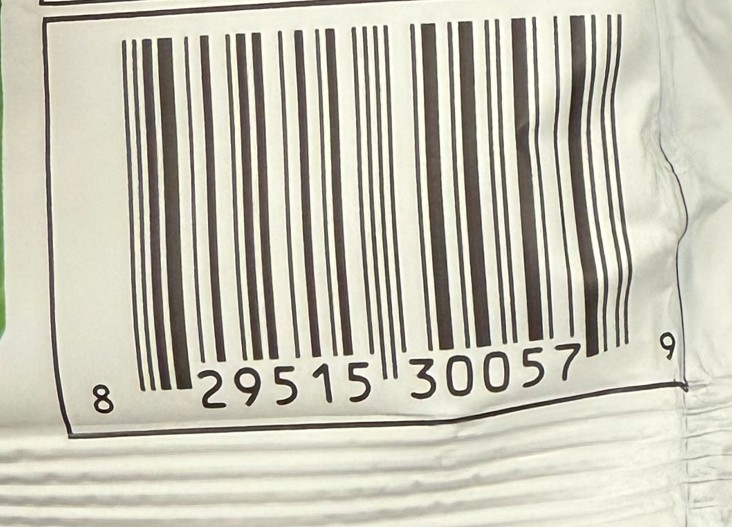

In [20]:
from pathlib import Path #Added recently

# img_path = Path("shared_image.jpg")
img_path = Path("barcode.jpg")
if img_path.exists():
    # Preview the image (fast, no Pillow needed)
    from IPython.display import display, Image as IPImage
    display(IPImage(filename=str(img_path)))  # shows the picture inline
else:
    print("[Info] Sample image not found; skipping image demo.")

Now let's see if our agent can extract the barcode and pass it to its barcode reader tool.

In [21]:

# # Image example (if file exists)
# img_path = Path("barcode.jpg")
# if img_path.exists():
#     mime = mimetypes.guess_type(str(img_path))[0] or "image/jpeg"
#     content = [
#         "Use the image: extract a barcode (remove all spaces and extra chars); and call off_by_barcode or off_search_by_name to list ingredients.",
#         BinaryContent(data=img_path.read_bytes(), media_type=mime),
#     ]
#     async with orchestrator_phase1_exa_off:
#         demo = await orchestrator_phase1_exa_off.run(content)
#         print(demo.output)
# else:
#     print("[Info] Sample image not found; skipping image demo.")


# Image example (if file exists)

from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
import mimetypes

app_name="Orchestrator Agent EXA App"

#create session for the app
session_service = InMemorySessionService()
await session_service.create_session(
            app_name=app_name,
            user_id="user_123",
            session_id="default_123",
        )

# runner for app
runner_1_exa = Runner(
    app_name=app_name, 
    agent=orchestrator_phase1_exa, 
    session_service=session_service
    )
# user query
# img_path = Path("barcode.jpg")
img_path = Path("shared_image.jpg")
if img_path.exists():
    mime = mimetypes.guess_type(str(img_path))[0] or "image/jpeg"
    content = [
        types.Part.from_text(
         text="Use the image: extract a barcode (remove all spaces and extra chars); and call off_by_barcode or off_search_by_name to list ingredients."
        ),
        types.Part.from_bytes(
            data=img_path.read_bytes(), 
            mime_type=mime
        )
    ]
    user_query = types.Content(role="user", parts=content)
    response = runner_1_exa.run(new_message=user_query, session_id="default_123", user_id="user_123")
    # for event in response:
    #     if event.is_final_response() and event.content:
    #             final_answer = event.content.parts[0].text.strip()
    #     print(event)
    # # print(response.)

    for event in response: # what are events here? 
        print(f"\nDEBUG EVENT: {event}\n")
        if event.is_final_response() and event.content:
            final_answer = event.content.parts[0].text.strip()
            print("\n🟢 FINAL ANSWER\n", final_answer, "\n")
else:
    print("[Info] Sample image not found; skipping image demo.")



DEBUG EVENT: model_version='hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8' content=Content(
  parts=[
    Part(
      function_call=FunctionCall(
        args={
          'ean_13': '8901123001214'
        },
        id='chatcmpl-tool-a6e7eb6ab3897a35',
        name='off_by_barcode_fn'
      )
    ),
  ],
  role='model'
) grounding_metadata=None partial=False turn_complete=None finish_reason=<FinishReason.STOP: 'STOP'> error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=GenerateContentResponseUsageMetadata(
  cached_content_token_count=0,
  candidates_token_count=38,
  prompt_token_count=1616,
  total_token_count=1654
) live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None interaction_id=None invocation_id='e-e4992869-1017-4146-8025-a213daa3c0c3' author='orchestrator_phase1_exa' actions=EventActions(skip_summarization=None, state_delta=

# 11) Wrap Consultant as a Tool

Expose the Consultant as a callable tool (e.g., `consult_nutritionist(...)`.

**Goals**
- Accept **product name** or **ingredient list** and an optional **goal** (e.g., `low_sodium`).
- Call the **Consultant agent** internally and **parse JSON** safely.
- Return a minimal **fallback** JSON if the consultant returns malformed data.


In [ ]:
# from typing import Optional

# async def consult_nutritionist_fn(
#     ingredients: List[str],
#     sodium_mg_per_serving: Optional[int] = None,
#     product_name: Optional[str] = None,
# ) -> dict:
#     print("consultant agent is called")
#     payload = {"product_name": product_name, "ingredients": ingredients}

#     async with consultant_agent:
#         res = await consultant_agent.run(json.dumps(payload))

#     try:
#         return json.loads(res.output)
#     except Exception:
#         return {
#             "overall": "uncertain",
#             "reasons": ["consultant returned non‑JSON"],
#             "warnings": [],
#             "alternatives": [],
#             "disclaimer": "Educational only; not medical advice.",
#         }

# consult_nutritionist = Tool(
#     consult_nutritionist_fn,
#     name="consult_nutritionist",
#     description="Evaluate ingredient list for high BP; returns JSON verdict.",
# )
# print("Consultant wrapped as tool: consult_nutritionist")


# 12) Final Version — Stick Everything Together

Build the final Orchestrator configuration that:
1. Uses **OFF tools** first for barcode/name lookups.
2. Falls back to **EXA (MCP)** only if OFF fails/ambiguous.
3. Calls the **Consultant tool** with either product name or cleaned ingredients.
4. Returns a compact **verdict + 1–3 reasons + 1–2 alternatives**, plus an educational disclaimer.

**Goals**
- Provide a brief **end-to-end** example (text-only and image-based).
- Keep outputs <= 6 lines and avoid leaking raw tool JSON.

In [ ]:
from google.adk.tools.agent_tool import AgentTool

consult_nutritionist = AgentTool(agent=nutritionist_agent)

root_agent = Agent(
    name="RootOrchestrator",
    model=LiteLlm(
        model=f"hosted_vllm/Qwen/Qwen3-VL-30B-A3B-Instruct-FP8",
        base_url=f"http://localhost:9001/v1",
    ),
    instruction=(
        """
        You are an Ingredient Orchestrator with tool access.
        
        Objective:
        Derive an ingredient list  (OFF or EXA) or from an explicit user‑provided list, then call nutritionist_agent with BOTH ingredients (list) and product_name, finally return the final verdict and summary.
        
        Data tools (priority):
        1) off_by_barcode_fn(ean_13) - FIRST if a 13‑digit barcode is present.
        2) off_search_by_name_fn(name) - If no barcode or lookup failed.
        3) web_search_exa(query) - FALLBACK ONLY if OFF fails/ambiguous or if user explicitly asks for freshest data.
        
        RULES:
        - NEVER fabricate ingredients from memory.
        - NEVER output an ingredients list unless it came from tools or the user.
        - If all tools fail, ask the user to paste the ingredients.
        - ALWAYS use nutritionist_agent when you have the ingredients.
        - NEVER suggest your own alternative, always rely on the response from nutritionist_agent
        
        Extraction rules:
        - OFF: prefer ingredients fields; preserve order; trim/dedupe.
        - Web: manufacturer > major retailer > reputable database. Ignore marketing blurbs and storage instructions.
        
        Consultant call:
        - After ingredients are ready, call nutritionist_agent with product_name and ingredients.
        - Do NOT call until ingredients are confirmed.
        
        Ambiguity:
        - If OFF returns multiple variants (country/flavor), ask ONE concise clarifying question.
        
        Final user answer format (≤ 6 lines):
        1) Verdict: OK / Caution / Avoid / Uncertain
        2-4) 1-3 short reasons
        5) Healthier alternative (if available)
        6) Educational only; not medical advice.
        
        **IMPORTANT** Include all the reasoning and actions you took as a summary for the user. Show the results you got from each tool call.
        """
    ),
    
    tools=[consult_nutritionist, off_by_barcode_fn, off_search_by_name_fn, *exa_tools] if exa_tools else [consult_nutritionist, off_by_barcode_fn, off_search_by_name_fn]
    # tools=[AgentTool(agent=nutritionist_agent),]
)

print("Final orchestrator ready.")


Time to test our E2E system.

In [ ]:
# async with orchestrator:
#     result = await orchestrator.run("Is Kitkat USA safe to eat for High Blood Pressure?")
#     print(result.output)


from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
import asyncio

app_name="Orchestrator Agent App"

enable_weave = True
if enable_weave:
    os.environ["WEAVE_SERVER_CACHE_DIR"] = "/home/$USER/.weave_cache"

    import base64
    from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
    from opentelemetry.sdk import trace as trace_sdk
    from opentelemetry.sdk.trace.export import SimpleSpanProcessor
    from opentelemetry import trace

    project_id = os.getenv('PROJECT_ID', "yogesh-test744-test/nurtion_agent_project-test")
    WANDB_BASE_URL = "https://trace.wandb.ai"
    OTEL_EXPORTER_OTLP_ENDPOINT = f"{WANDB_BASE_URL}/otel/v1/traces"

    wandb_api_key = os.getenv("WANDB_API_KEY", "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")
    AUTH = base64.b64encode(f"api:{wandb_api_key}".encode()).decode()

    OTEL_EXPORTER_OTLP_HEADERS = {
        "Authorization": f"Basic {AUTH}",
        "project_id": project_id,
    }

    exporter = OTLPSpanExporter(
        endpoint=OTEL_EXPORTER_OTLP_ENDPOINT,
        headers=OTEL_EXPORTER_OTLP_HEADERS,
    )

    tracer_provider = trace_sdk.TracerProvider()
    tracer_provider.add_span_processor(SimpleSpanProcessor(exporter))

    trace.set_tracer_provider(tracer_provider)

#create session for the app
session_service = InMemorySessionService()
await session_service.create_session(
            app_name=app_name,
            user_id="user_123",
            session_id="default_123",
        )

# runner for app
root_runner = Runner(
    app_name=app_name, 
    agent=root_agent, 
    session_service=session_service
    )


# user query
# query = "Is Kitkat safe to eat for High Blood Pressure?"
query = "Is Limca safe to drink when I have Fever?"
user_query = types.Content(role="user", parts=[types.Part.from_text(text=query)])

# img_path = Path("shared_image.jpg")
# if img_path.exists():
#     mime = mimetypes.guess_type(str(img_path))[0] or "image/jpeg"
#     content = [
#         types.Part.from_text(
#          text="Use the image: extract a barcode (remove all spaces and extra chars); and call off_by_barcode or off_search_by_name to list ingredients."
#         ),
#         types.Part.from_bytes(
#             data=img_path.read_bytes(), 
#             mime_type=mime
#         )
#     ]
#     user_query = types.Content(role="user", parts=content)


response =  root_runner.run_async(new_message=user_query, session_id="default_123", user_id="user_123")
# for event in response:
#     if event.is_final_response() and event.content:
#             final_answer = event.content.parts[0].text.strip()
#     print(event)
# # print(response.)

async for event in response: # what are events here? 
    print(f"\nDEBUG EVENT: {event}\n")
    if event.is_final_response() and event.content:
        final_answer = event.content.parts[0].text.strip()
        print("\n🟢 FINAL ANSWER\n", final_answer, "\n")

# 13) Bonus Challenge — Total Calories per Pack (Barcode Only)

Extend your agent so that, when given a **barcode**, it returns the **total calories for one full pack** of the item.

**What counts as a win (prize criterion):**
- Given just a **barcode** (text or image), your Orchestrator should output:  
  **“Total calories (per pack): ** (along with the usual brief verdict + reasons if you like).

In [ ]:
# TODO: extend your agent to provide total calories per pack based on weight.